In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import os
from PIL import Image
from tqdm import tqdm
import glob

In [ ]:
class AODnet(nn.Module):
    def __init__(self):
        super(AODnet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=1, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=6, out_channels=3, kernel_size=5, stride=1, padding=2)
        self.conv4 = nn.Conv2d(in_channels=6, out_channels=3, kernel_size=7, stride=1, padding=3)
        self.conv5 = nn.Conv2d(in_channels=12, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.b = 1

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x1))
        cat1 = torch.cat((x1, x2), 1)
        x3 = F.relu(self.conv3(cat1))
        cat2 = torch.cat((x2, x3), 1)
        x4 = F.relu(self.conv4(cat2))
        cat3 = torch.cat((x1, x2, x3, x4), 1)
        k = F.relu(self.conv5(cat3))

        if k.size() != x.size():
            raise Exception("k, haze image are different size!")

        output = k * x - k + self.b
        return F.relu(output)

class PONO(nn.Module):
    def __init__(self, input_size=None, return_stats=False, affine=True, eps=1e-5):
        super(PONO, self).__init__()
        self.return_stats = return_stats
        self.input_size = input_size
        self.eps = eps
        self.affine = affine
        if affine:
            self.beta = nn.Parameter(torch.zeros(1, 1, *input_size)) if input_size is not None else None
            self.gamma = nn.Parameter(torch.ones(1, 1, *input_size)) if input_size is not None else None
        else:
            self.beta, self.gamma = None, None
    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        std = (x.var(dim=1, keepdim=True) + self.eps).sqrt()
        x = (x - mean) / std
        if self.affine:
            x = x * self.gamma + self.beta
        return x, mean, std

class MS(nn.Module):
    def __init__(self, beta=None, gamma=None):
        super(MS, self).__init__()
        self.gamma, self.beta = gamma, beta

    def forward(self, x, beta=None, gamma=None):
        beta = self.beta if beta is None else beta
        gamma = self.gamma if gamma is None else gamma
        if gamma is not None:
            x = x * gamma  # ★★★ 수정된 부분 ★★★
        if beta is not None:
            x = x + beta   # ★★★ 수정된 부분 ★★★
        return x

class AOD_pono_net(nn.Module):
    def __init__(self):
        super(AOD_pono_net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=1, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=6, out_channels=3, kernel_size=5, stride=1, padding=2)
        self.conv4 = nn.Conv2d(in_channels=6, out_channels=3, kernel_size=7, stride=1, padding=3)
        self.conv5 = nn.Conv2d(in_channels=12, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.b = 1
        self.pono = PONO(affine=False)
        self.ms = MS()
    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x1))
        cat1 = torch.cat((x1, x2), 1)
        x1, mean1, std1 = self.pono(x1)
        x2, mean2, std2 = self.pono(x2)
        x3 = F.relu(self.conv3(cat1))
        cat2 = torch.cat((x2, x3), 1)
        x3 = self.ms(x3, mean1, std1)
        x4 = F.relu(self.conv4(cat2))
        x4 = self.ms(x4, mean2, std2)
        cat3 = torch.cat((x1, x2, x3, x4), 1)
        k = F.relu(self.conv5(cat3))
        if k.size() != x.size():
            raise Exception("k, haze image are different size!")
        output = k * x - k + self.b
        return F.relu(output)

In [3]:
def print_model_summary(model, model_name):
    """모델의 파라미터 정보와 총 개수를 출력하는 함수"""
    print(f"========== {model_name} Summary ==========")
    
    # 모델의 각 파라미터 이름과 크기(shape) 출력
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"Layer: {name},  Shape: {param.shape}")
    
    # 전체 파라미터 개수 계산 및 출력
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal trainable parameters: {total_params:,}")
    print("=" * (len(model_name) + 24))
    print("\n")


# 1. AODnet 모델 객체 생성 및 파라미터 확인
aod_model = AODnet()
print_model_summary(aod_model, "AODnet")

# 2. AOD_pono_net 모델 객체 생성 및 파라미터 확인
# PONO의 affine=False이므로 추가 파라미터가 없습니다.
aod_pono_model = AOD_pono_net()
print_model_summary(aod_pono_model, "AOD_pono_net")

========== AODnet Summary ==========
Layer: conv1.weight,  Shape: torch.Size([3, 3, 1, 1])
Layer: conv1.bias,  Shape: torch.Size([3])
Layer: conv2.weight,  Shape: torch.Size([3, 3, 3, 3])
Layer: conv2.bias,  Shape: torch.Size([3])
Layer: conv3.weight,  Shape: torch.Size([3, 6, 5, 5])
Layer: conv3.bias,  Shape: torch.Size([3])
Layer: conv4.weight,  Shape: torch.Size([3, 6, 7, 7])
Layer: conv4.bias,  Shape: torch.Size([3])
Layer: conv5.weight,  Shape: torch.Size([3, 12, 3, 3])
Layer: conv5.bias,  Shape: torch.Size([3])

Total trainable parameters: 1,761


========== AOD_pono_net Summary ==========
Layer: conv1.weight,  Shape: torch.Size([3, 3, 1, 1])
Layer: conv1.bias,  Shape: torch.Size([3])
Layer: conv2.weight,  Shape: torch.Size([3, 3, 3, 3])
Layer: conv2.bias,  Shape: torch.Size([3])
Layer: conv3.weight,  Shape: torch.Size([3, 6, 5, 5])
Layer: conv3.bias,  Shape: torch.Size([3])
Layer: conv4.weight,  Shape: torch.Size([3, 6, 7, 7])
Layer: conv4.bias,  Shape: torch.Size([3])
Layer: co

In [4]:
class DehazeDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        """
        :param data_dir: train, test, val 폴더 중 하나의 경로 (예: 'dataset2_split/train')
        :param transform: 이미지에 적용할 torchvision.transforms
        """
        self.gt_dir = os.path.join(data_dir, 'gt')
        self.input_dir = os.path.join(data_dir, 'input')
        self.transform = transform
        
        # input 폴더의 파일 목록을 기준으로 삼음
        self.image_files = os.listdir(self.input_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        filename = self.image_files[idx]
        
        input_path = os.path.join(self.input_dir, filename)
        gt_path = os.path.join(self.gt_dir, filename)
        
        # PIL 라이브러리를 사용해 이미지 열기 (RGB 형식으로 변환)
        input_image = Image.open(input_path).convert('RGB')
        gt_image = Image.open(gt_path).convert('RGB')
        
        if self.transform:
            input_image = self.transform(input_image)
            gt_image = self.transform(gt_image)
            
        return input_image, gt_image

In [5]:
# GPU 사용 설정
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# 하이퍼파라미터
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
NUM_EPOCHS = 100

# 데이터셋 경로 (split_dataset.py 실행 후 생성된 폴더)
DATA_DIR = "./dataset_split"
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')

# 학습된 모델 가중치를 저장할 경로
MODEL_SAVE_PATH = "./pt/aodNet"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

Using device: cuda


In [6]:
# 이미지 변환 설정
transform = transforms.Compose([
    transforms.Resize((360, 240)), # 이미지 크기를 256x256으로 조절 H, W 순서
    transforms.ToTensor()          # 이미지를 PyTorch 텐서로 변환 (0~1 값으로 정규화)
])

# 훈련 데이터셋 및 데이터 로더
train_dataset = DehazeDataset(data_dir=TRAIN_DIR, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# 검증 데이터셋 및 데이터 로더
val_dataset = DehazeDataset(data_dir=VAL_DIR, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"훈련 데이터셋 크기: {len(train_dataset)}개")
print(f"검증 데이터셋 크기: {len(val_dataset)}개")

# 셀 5 실행 후 이 코드를 실행해보세요
try:
    input_img, gt_img = train_dataset[0]
    print("데이터셋 로딩 성공!")
    print("Input 이미지 텐서 모양:", input_img.shape)
    print("GT 이미지 텐서 모양:", gt_img.shape)
except Exception as e:
    print("데이터셋 로딩 중 오류 발생:", e)

훈련 데이터셋 크기: 3543개
검증 데이터셋 크기: 507개
데이터셋 로딩 성공!
Input 이미지 텐서 모양: torch.Size([3, 360, 240])
GT 이미지 텐서 모양: torch.Size([3, 360, 240])


In [7]:
# 모델 인스턴스 생성 및 GPU로 이동
# model = AODnet().to(DEVICE) # 기본 모델을 사용하려면 이 줄의 주석을 해제
model = AODnet().to(DEVICE) # PONO 모델 사용
print("Model:", model.__class__.__name__)

# 손실 함수 (Loss Function) - 이미지 복원에는 MSE Loss가 일반적으로 사용됨
criterion = nn.MSELoss()

# 옵티마이저 (Optimizer) - Adam이 안정적이고 좋은 성능을 보임
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Model: AODnet


In [8]:
# 각 에폭의 손실 값을 저장할 리스트 생성
train_loss_history = [] # <<< 추가
val_loss_history = []   # <<< 추가

best_val_loss = float('inf')

print("\n===== 모델 학습을 시작합니다 =====")
for epoch in range(NUM_EPOCHS):
    # --- 훈련 단계 ---
    model.train()
    train_loss = 0.0
    
    train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    for hazy_images, clean_images in train_iterator:
        hazy_images = hazy_images.to(DEVICE)
        clean_images = clean_images.to(DEVICE)
        
        outputs = model(hazy_images)
        loss = criterion(outputs, clean_images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_iterator.set_postfix({'loss': loss.item()})
        
    avg_train_loss = train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss) # <<< 추가

    # --- 검증 단계 ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        val_iterator = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]")
        for hazy_images, clean_images in val_iterator:
            hazy_images = hazy_images.to(DEVICE)
            clean_images = clean_images.to(DEVICE)
            
            outputs = model(hazy_images)
            loss = criterion(outputs, clean_images)
            val_loss += loss.item()
            val_iterator.set_postfix({'loss': loss.item()})
            
    avg_val_loss = val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss) # <<< 추가
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        save_file = os.path.join(MODEL_SAVE_PATH, f"best_model_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), save_file)
        print(f"***** Best model saved to {save_file} (Val Loss: {best_val_loss:.6f}) *****\n")

print("\n===== 모든 학습이 완료되었습니다! =====")


===== 모델 학습을 시작합니다 =====


Epoch 1/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.68it/s, loss=0.0101] 


Epoch [1/100], Train Loss: 0.111843, Val Loss: 0.026090
***** Best model saved to ./pt/aodNet\best_model_epoch_1.pth (Val Loss: 0.026090) *****



Epoch 2/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.69it/s, loss=0.00958]


Epoch [2/100], Train Loss: 0.026404, Val Loss: 0.025563
***** Best model saved to ./pt/aodNet\best_model_epoch_2.pth (Val Loss: 0.025563) *****



Epoch 3/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.91it/s, loss=0.00953]


Epoch [3/100], Train Loss: 0.025768, Val Loss: 0.024985
***** Best model saved to ./pt/aodNet\best_model_epoch_3.pth (Val Loss: 0.024985) *****



Epoch 4/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.83it/s, loss=0.00974]


Epoch [4/100], Train Loss: 0.025049, Val Loss: 0.024312
***** Best model saved to ./pt/aodNet\best_model_epoch_4.pth (Val Loss: 0.024312) *****



Epoch 5/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.68it/s, loss=0.00956]


Epoch [5/100], Train Loss: 0.024457, Val Loss: 0.023700
***** Best model saved to ./pt/aodNet\best_model_epoch_5.pth (Val Loss: 0.023700) *****



Epoch 6/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.69it/s, loss=0.0101] 


Epoch [6/100], Train Loss: 0.023961, Val Loss: 0.023421
***** Best model saved to ./pt/aodNet\best_model_epoch_6.pth (Val Loss: 0.023421) *****



Epoch 7/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.84it/s, loss=0.0113]


Epoch [7/100], Train Loss: 0.023711, Val Loss: 0.023513


Epoch 8/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.65it/s, loss=0.0106] 


Epoch [8/100], Train Loss: 0.023589, Val Loss: 0.023181
***** Best model saved to ./pt/aodNet\best_model_epoch_8.pth (Val Loss: 0.023181) *****



Epoch 9/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.88it/s, loss=0.0113]


Epoch [9/100], Train Loss: 0.023560, Val Loss: 0.023260


Epoch 10/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.81it/s, loss=0.0103] 


Epoch [10/100], Train Loss: 0.023276, Val Loss: 0.022755
***** Best model saved to ./pt/aodNet\best_model_epoch_10.pth (Val Loss: 0.022755) *****



Epoch 11/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.82it/s, loss=0.0105] 


Epoch [11/100], Train Loss: 0.023062, Val Loss: 0.022713
***** Best model saved to ./pt/aodNet\best_model_epoch_11.pth (Val Loss: 0.022713) *****



Epoch 12/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.64it/s, loss=0.00894]


Epoch [12/100], Train Loss: 0.022850, Val Loss: 0.022463
***** Best model saved to ./pt/aodNet\best_model_epoch_12.pth (Val Loss: 0.022463) *****



Epoch 13/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.62it/s, loss=0.00826]


Epoch [13/100], Train Loss: 0.022890, Val Loss: 0.022576


Epoch 14/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.78it/s, loss=0.00881]


Epoch [14/100], Train Loss: 0.022821, Val Loss: 0.022339
***** Best model saved to ./pt/aodNet\best_model_epoch_14.pth (Val Loss: 0.022339) *****



Epoch 15/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.88it/s, loss=0.00926]


Epoch [15/100], Train Loss: 0.022653, Val Loss: 0.022264
***** Best model saved to ./pt/aodNet\best_model_epoch_15.pth (Val Loss: 0.022264) *****



Epoch 16/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.89it/s, loss=0.00868]


Epoch [16/100], Train Loss: 0.022762, Val Loss: 0.022258
***** Best model saved to ./pt/aodNet\best_model_epoch_16.pth (Val Loss: 0.022258) *****



Epoch 17/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.86it/s, loss=0.00981]


Epoch [17/100], Train Loss: 0.022637, Val Loss: 0.022238
***** Best model saved to ./pt/aodNet\best_model_epoch_17.pth (Val Loss: 0.022238) *****



Epoch 18/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.75it/s, loss=0.00887]


Epoch [18/100], Train Loss: 0.022627, Val Loss: 0.022153
***** Best model saved to ./pt/aodNet\best_model_epoch_18.pth (Val Loss: 0.022153) *****



Epoch 19/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.87it/s, loss=0.00956]


Epoch [19/100], Train Loss: 0.022636, Val Loss: 0.022140
***** Best model saved to ./pt/aodNet\best_model_epoch_19.pth (Val Loss: 0.022140) *****



Epoch 20/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.73it/s, loss=0.00923]


Epoch [20/100], Train Loss: 0.022527, Val Loss: 0.022104
***** Best model saved to ./pt/aodNet\best_model_epoch_20.pth (Val Loss: 0.022104) *****



Epoch 21/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.81it/s, loss=0.00953]


Epoch [21/100], Train Loss: 0.022493, Val Loss: 0.022098
***** Best model saved to ./pt/aodNet\best_model_epoch_21.pth (Val Loss: 0.022098) *****



Epoch 22/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.55it/s, loss=0.0112]


Epoch [22/100], Train Loss: 0.022478, Val Loss: 0.022529


Epoch 23/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.75it/s, loss=0.00999]


Epoch [23/100], Train Loss: 0.022423, Val Loss: 0.022125


Epoch 24/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.72it/s, loss=0.00896]


Epoch [24/100], Train Loss: 0.022468, Val Loss: 0.021983
***** Best model saved to ./pt/aodNet\best_model_epoch_24.pth (Val Loss: 0.021983) *****



Epoch 25/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.89it/s, loss=0.0118]


Epoch [25/100], Train Loss: 0.022429, Val Loss: 0.022724


Epoch 26/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.67it/s, loss=0.00989]


Epoch [26/100], Train Loss: 0.022348, Val Loss: 0.022053


Epoch 27/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.80it/s, loss=0.0101] 


Epoch [27/100], Train Loss: 0.022368, Val Loss: 0.022061


Epoch 28/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.66it/s, loss=0.00935]


Epoch [28/100], Train Loss: 0.022340, Val Loss: 0.021934
***** Best model saved to ./pt/aodNet\best_model_epoch_28.pth (Val Loss: 0.021934) *****



Epoch 29/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.91it/s, loss=0.00841]


Epoch [29/100], Train Loss: 0.022271, Val Loss: 0.021916
***** Best model saved to ./pt/aodNet\best_model_epoch_29.pth (Val Loss: 0.021916) *****



Epoch 30/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.80it/s, loss=0.0083] 


Epoch [30/100], Train Loss: 0.022304, Val Loss: 0.021921


Epoch 31/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.81it/s, loss=0.0104]


Epoch [31/100], Train Loss: 0.022331, Val Loss: 0.022153


Epoch 32/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.82it/s, loss=0.00869]


Epoch [32/100], Train Loss: 0.022289, Val Loss: 0.021822
***** Best model saved to ./pt/aodNet\best_model_epoch_32.pth (Val Loss: 0.021822) *****



Epoch 33/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.84it/s, loss=0.00907]


Epoch [33/100], Train Loss: 0.022265, Val Loss: 0.021802
***** Best model saved to ./pt/aodNet\best_model_epoch_33.pth (Val Loss: 0.021802) *****



Epoch 34/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.59it/s, loss=0.00872]


Epoch [34/100], Train Loss: 0.022213, Val Loss: 0.021788
***** Best model saved to ./pt/aodNet\best_model_epoch_34.pth (Val Loss: 0.021788) *****



Epoch 35/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.70it/s, loss=0.00953]


Epoch [35/100], Train Loss: 0.022227, Val Loss: 0.021855


Epoch 36/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.72it/s, loss=0.00794]


Epoch [36/100], Train Loss: 0.022199, Val Loss: 0.021920


Epoch 37/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.71it/s, loss=0.00944]


Epoch [37/100], Train Loss: 0.022153, Val Loss: 0.021803


Epoch 38/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.62it/s, loss=0.00884]


Epoch [38/100], Train Loss: 0.022202, Val Loss: 0.021740
***** Best model saved to ./pt/aodNet\best_model_epoch_38.pth (Val Loss: 0.021740) *****



Epoch 39/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.89it/s, loss=0.0092] 


Epoch [39/100], Train Loss: 0.022188, Val Loss: 0.021769


Epoch 40/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.78it/s, loss=0.00868]


Epoch [40/100], Train Loss: 0.022095, Val Loss: 0.021771


Epoch 41/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.71it/s, loss=0.00928]


Epoch [41/100], Train Loss: 0.022128, Val Loss: 0.021743


Epoch 42/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.75it/s, loss=0.00952]


Epoch [42/100], Train Loss: 0.022164, Val Loss: 0.021790


Epoch 43/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.76it/s, loss=0.00883]


Epoch [43/100], Train Loss: 0.022133, Val Loss: 0.021685
***** Best model saved to ./pt/aodNet\best_model_epoch_43.pth (Val Loss: 0.021685) *****



Epoch 44/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.67it/s, loss=0.00885]


Epoch [44/100], Train Loss: 0.022167, Val Loss: 0.021678
***** Best model saved to ./pt/aodNet\best_model_epoch_44.pth (Val Loss: 0.021678) *****



Epoch 45/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.73it/s, loss=0.0102] 


Epoch [45/100], Train Loss: 0.022136, Val Loss: 0.021948


Epoch 46/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.67it/s, loss=0.00759]


Epoch [46/100], Train Loss: 0.022110, Val Loss: 0.021974


Epoch 47/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.81it/s, loss=0.00901]


Epoch [47/100], Train Loss: 0.022048, Val Loss: 0.021682


Epoch 48/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.82it/s, loss=0.00963]


Epoch [48/100], Train Loss: 0.022073, Val Loss: 0.021772


Epoch 49/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.83it/s, loss=0.00927]


Epoch [49/100], Train Loss: 0.022123, Val Loss: 0.021718


Epoch 50/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.76it/s, loss=0.00878]


Epoch [50/100], Train Loss: 0.022094, Val Loss: 0.021634
***** Best model saved to ./pt/aodNet\best_model_epoch_50.pth (Val Loss: 0.021634) *****



Epoch 51/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.87it/s, loss=0.00823]


Epoch [51/100], Train Loss: 0.022103, Val Loss: 0.021674


Epoch 52/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.80it/s, loss=0.00799]


Epoch [52/100], Train Loss: 0.022086, Val Loss: 0.021717


Epoch 53/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.89it/s, loss=0.00805]


Epoch [53/100], Train Loss: 0.022095, Val Loss: 0.021732


Epoch 54/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.67it/s, loss=0.00935]


Epoch [54/100], Train Loss: 0.022043, Val Loss: 0.021665


Epoch 55/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.55it/s, loss=0.00842]


Epoch [55/100], Train Loss: 0.022086, Val Loss: 0.021626
***** Best model saved to ./pt/aodNet\best_model_epoch_55.pth (Val Loss: 0.021626) *****



Epoch 56/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.65it/s, loss=0.00875]


Epoch [56/100], Train Loss: 0.022102, Val Loss: 0.021639


Epoch 57/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.71it/s, loss=0.00845]


Epoch [57/100], Train Loss: 0.022057, Val Loss: 0.021607
***** Best model saved to ./pt/aodNet\best_model_epoch_57.pth (Val Loss: 0.021607) *****



Epoch 58/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.71it/s, loss=0.00818]


Epoch [58/100], Train Loss: 0.022056, Val Loss: 0.021632


Epoch 59/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.70it/s, loss=0.00897]


Epoch [59/100], Train Loss: 0.022121, Val Loss: 0.021595
***** Best model saved to ./pt/aodNet\best_model_epoch_59.pth (Val Loss: 0.021595) *****



Epoch 60/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.73it/s, loss=0.00876]


Epoch [60/100], Train Loss: 0.022080, Val Loss: 0.021590
***** Best model saved to ./pt/aodNet\best_model_epoch_60.pth (Val Loss: 0.021590) *****



Epoch 61/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.86it/s, loss=0.00841]


Epoch [61/100], Train Loss: 0.022063, Val Loss: 0.021589
***** Best model saved to ./pt/aodNet\best_model_epoch_61.pth (Val Loss: 0.021589) *****



Epoch 62/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.75it/s, loss=0.00869]


Epoch [62/100], Train Loss: 0.022028, Val Loss: 0.021572
***** Best model saved to ./pt/aodNet\best_model_epoch_62.pth (Val Loss: 0.021572) *****



Epoch 63/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.75it/s, loss=0.00864]


Epoch [63/100], Train Loss: 0.022045, Val Loss: 0.021569
***** Best model saved to ./pt/aodNet\best_model_epoch_63.pth (Val Loss: 0.021569) *****



Epoch 64/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.61it/s, loss=0.00885]


Epoch [64/100], Train Loss: 0.022019, Val Loss: 0.021574


Epoch 65/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.88it/s, loss=0.00828]


Epoch [65/100], Train Loss: 0.021985, Val Loss: 0.021583


Epoch 66/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.65it/s, loss=0.00911]


Epoch [66/100], Train Loss: 0.022009, Val Loss: 0.021585


Epoch 67/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.79it/s, loss=0.00824]


Epoch [67/100], Train Loss: 0.021965, Val Loss: 0.021585


Epoch 68/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.58it/s, loss=0.00938]


Epoch [68/100], Train Loss: 0.022139, Val Loss: 0.021616


Epoch 69/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.77it/s, loss=0.00856]


Epoch [69/100], Train Loss: 0.021996, Val Loss: 0.021560
***** Best model saved to ./pt/aodNet\best_model_epoch_69.pth (Val Loss: 0.021560) *****



Epoch 70/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.75it/s, loss=0.00869]


Epoch [70/100], Train Loss: 0.021987, Val Loss: 0.021543
***** Best model saved to ./pt/aodNet\best_model_epoch_70.pth (Val Loss: 0.021543) *****



Epoch 71/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.90it/s, loss=0.00823]


Epoch [71/100], Train Loss: 0.021985, Val Loss: 0.021572


Epoch 72/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.48it/s, loss=0.0079] 


Epoch [72/100], Train Loss: 0.021965, Val Loss: 0.021689


Epoch 73/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.94it/s, loss=0.00819]


Epoch [73/100], Train Loss: 0.021947, Val Loss: 0.021565


Epoch 74/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.72it/s, loss=0.00829]


Epoch [74/100], Train Loss: 0.022005, Val Loss: 0.021543
***** Best model saved to ./pt/aodNet\best_model_epoch_74.pth (Val Loss: 0.021543) *****



Epoch 75/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.88it/s, loss=0.00915]


Epoch [75/100], Train Loss: 0.021997, Val Loss: 0.021574


Epoch 76/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.74it/s, loss=0.00793]


Epoch [76/100], Train Loss: 0.021974, Val Loss: 0.021558


Epoch 77/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.75it/s, loss=0.00801]


Epoch [77/100], Train Loss: 0.021960, Val Loss: 0.021561


Epoch 78/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.64it/s, loss=0.00824]


Epoch [78/100], Train Loss: 0.021967, Val Loss: 0.021525
***** Best model saved to ./pt/aodNet\best_model_epoch_78.pth (Val Loss: 0.021525) *****



Epoch 79/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 11.02it/s, loss=0.00917]


Epoch [79/100], Train Loss: 0.021963, Val Loss: 0.021549


Epoch 80/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.59it/s, loss=0.00749]


Epoch [80/100], Train Loss: 0.021921, Val Loss: 0.021863


Epoch 81/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.71it/s, loss=0.00842]


Epoch [81/100], Train Loss: 0.021980, Val Loss: 0.021479
***** Best model saved to ./pt/aodNet\best_model_epoch_81.pth (Val Loss: 0.021479) *****



Epoch 82/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.65it/s, loss=0.0081] 


Epoch [82/100], Train Loss: 0.021877, Val Loss: 0.021538


Epoch 83/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.86it/s, loss=0.00918]


Epoch [83/100], Train Loss: 0.021904, Val Loss: 0.021545


Epoch 84/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.68it/s, loss=0.00808]


Epoch [84/100], Train Loss: 0.021884, Val Loss: 0.021509


Epoch 85/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.72it/s, loss=0.00837]


Epoch [85/100], Train Loss: 0.021885, Val Loss: 0.021466
***** Best model saved to ./pt/aodNet\best_model_epoch_85.pth (Val Loss: 0.021466) *****



Epoch 86/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.65it/s, loss=0.00879]


Epoch [86/100], Train Loss: 0.021916, Val Loss: 0.021479


Epoch 87/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.77it/s, loss=0.00876]


Epoch [87/100], Train Loss: 0.021896, Val Loss: 0.021463
***** Best model saved to ./pt/aodNet\best_model_epoch_87.pth (Val Loss: 0.021463) *****



Epoch 88/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.72it/s, loss=0.00867]


Epoch [88/100], Train Loss: 0.021906, Val Loss: 0.021464


Epoch 89/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.64it/s, loss=0.00912]


Epoch [89/100], Train Loss: 0.021894, Val Loss: 0.021517


Epoch 90/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.76it/s, loss=0.00812]


Epoch [90/100], Train Loss: 0.021958, Val Loss: 0.021466


Epoch 91/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.53it/s, loss=0.00852]


Epoch [91/100], Train Loss: 0.021916, Val Loss: 0.021497


Epoch 92/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.69it/s, loss=0.00875]


Epoch [92/100], Train Loss: 0.021905, Val Loss: 0.021444
***** Best model saved to ./pt/aodNet\best_model_epoch_92.pth (Val Loss: 0.021444) *****



Epoch 93/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.76it/s, loss=0.00855]


Epoch [93/100], Train Loss: 0.021927, Val Loss: 0.021437
***** Best model saved to ./pt/aodNet\best_model_epoch_93.pth (Val Loss: 0.021437) *****



Epoch 94/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.55it/s, loss=0.00895]


Epoch [94/100], Train Loss: 0.021852, Val Loss: 0.021458


Epoch 95/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.78it/s, loss=0.0102] 


Epoch [95/100], Train Loss: 0.021863, Val Loss: 0.021847


Epoch 96/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.66it/s, loss=0.00842]


Epoch [96/100], Train Loss: 0.021924, Val Loss: 0.021426
***** Best model saved to ./pt/aodNet\best_model_epoch_96.pth (Val Loss: 0.021426) *****



Epoch 97/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.70it/s, loss=0.00946]


Epoch [97/100], Train Loss: 0.021846, Val Loss: 0.021564


Epoch 98/100 [Val]: 100%|██████████| 32/32 [00:02<00:00, 10.67it/s, loss=0.00996]


Epoch [98/100], Train Loss: 0.021897, Val Loss: 0.021776


Epoch 99/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.52it/s, loss=0.00972]


Epoch [99/100], Train Loss: 0.021869, Val Loss: 0.021606


Epoch 100/100 [Val]: 100%|██████████| 32/32 [00:03<00:00, 10.59it/s, loss=0.00824]

Epoch [100/100], Train Loss: 0.021853, Val Loss: 0.021441

===== 모든 학습이 완료되었습니다! =====


In [9]:
# 새로운 셀

import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# --- 설정 (★★★ 사용 전 꼭 수정해주세요 ★★★) ---
# 1. 평가에 사용할 테스트셋 폴더 경로
TEST_DIR = os.path.join(DATA_DIR, 'test')

# 2. 불러올 학습된 모델 가중치 파일의 경로
# 'trained_models' 폴더 안에 저장된 .pth 파일 중 가장 성능이 좋았던(best) 모델의 경로를 지정합니다.
MODEL_WEIGHTS_PATH = "pt/aodNet/best_model_epoch_96.pth" # XX 부분은 실제 파일 숫자로 변경
# --------------------------------------------------

# 모델 구조 로드 및 가중치 불러오기
evaluation_model = AOD_pono_net().to(DEVICE)
evaluation_model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=DEVICE))
evaluation_model.eval() # 모델을 반드시 평가 모드로 설정!

# 테스트 데이터 로더 준비
test_dataset = DehazeDataset(data_dir=TEST_DIR, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0) # num_workers=0으로 설정

# 점수를 저장할 리스트 초기화
psnr_scores = []
ssim_scores = []

print(f"\n===== '{MODEL_WEIGHTS_PATH}' 모델 성능 평가 시작 =====")

# 평가 루프
with torch.no_grad(): # 기울기 계산 비활성화
    for hazy_images, clean_images in tqdm(test_loader, desc="Evaluating"):
        hazy_images = hazy_images.to(DEVICE)
        
        # 모델 추론
        outputs = evaluation_model(hazy_images)
        
        # GPU 텐서를 CPU의 Numpy 배열로 변환 (skimage 계산용)
        # (B, C, H, W) -> (B, H, W, C) 형태로 변경 및 0-255 범위의 정수형으로 변환
        outputs_np = outputs.cpu().permute(0, 2, 3, 1).numpy() * 255
        clean_images_np = clean_images.cpu().permute(0, 2, 3, 1).numpy() * 255
        
        outputs_np = outputs_np.astype(np.uint8)
        clean_images_np = clean_images_np.astype(np.uint8)
        
        # 배치 내의 각 이미지에 대해 점수 계산
        for i in range(clean_images_np.shape[0]):
            gt_image = clean_images_np[i]
            pred_image = outputs_np[i]
            
            # PSNR 계산
            psnr = peak_signal_noise_ratio(gt_image, pred_image, data_range=255)
            psnr_scores.append(psnr)
            
            # SSIM 계산
            # channel_axis=-1 은 컬러 이미지(RGB)의 채널 축을 지정해줍니다.
            ssim = structural_similarity(gt_image, pred_image, channel_axis=-1, data_range=255)
            ssim_scores.append(ssim)

# 평균 점수 계산
avg_psnr = np.mean(psnr_scores)
avg_ssim = np.mean(ssim_scores)

print("\n===== 평가 완료 =====")
print(f"테스트 데이터셋 평균 PSNR: {avg_psnr:.4f} dB")
print(f"테스트 데이터셋 평균 SSIM: {avg_ssim:.4f}")


===== 'pt/aodNet/best_model_epoch_96.pth' 모델 성능 평가 시작 =====


Evaluating: 100%|██████████| 127/127 [00:22<00:00,  5.75it/s]


===== 평가 완료 =====
테스트 데이터셋 평균 PSNR: 16.4236 dB
테스트 데이터셋 평균 SSIM: 0.6498


이미지 복원을 시작합니다...
'dataset_split/test/input/51_rain.png' 복원 및 정답 이미지 로드 완료.
'dataset_split/test/input/im_0048_s95_a06.png' 복원 및 정답 이미지 로드 완료.
'dataset_split/test/input/NYU2_1331.jpg' 복원 및 정답 이미지 로드 완료.


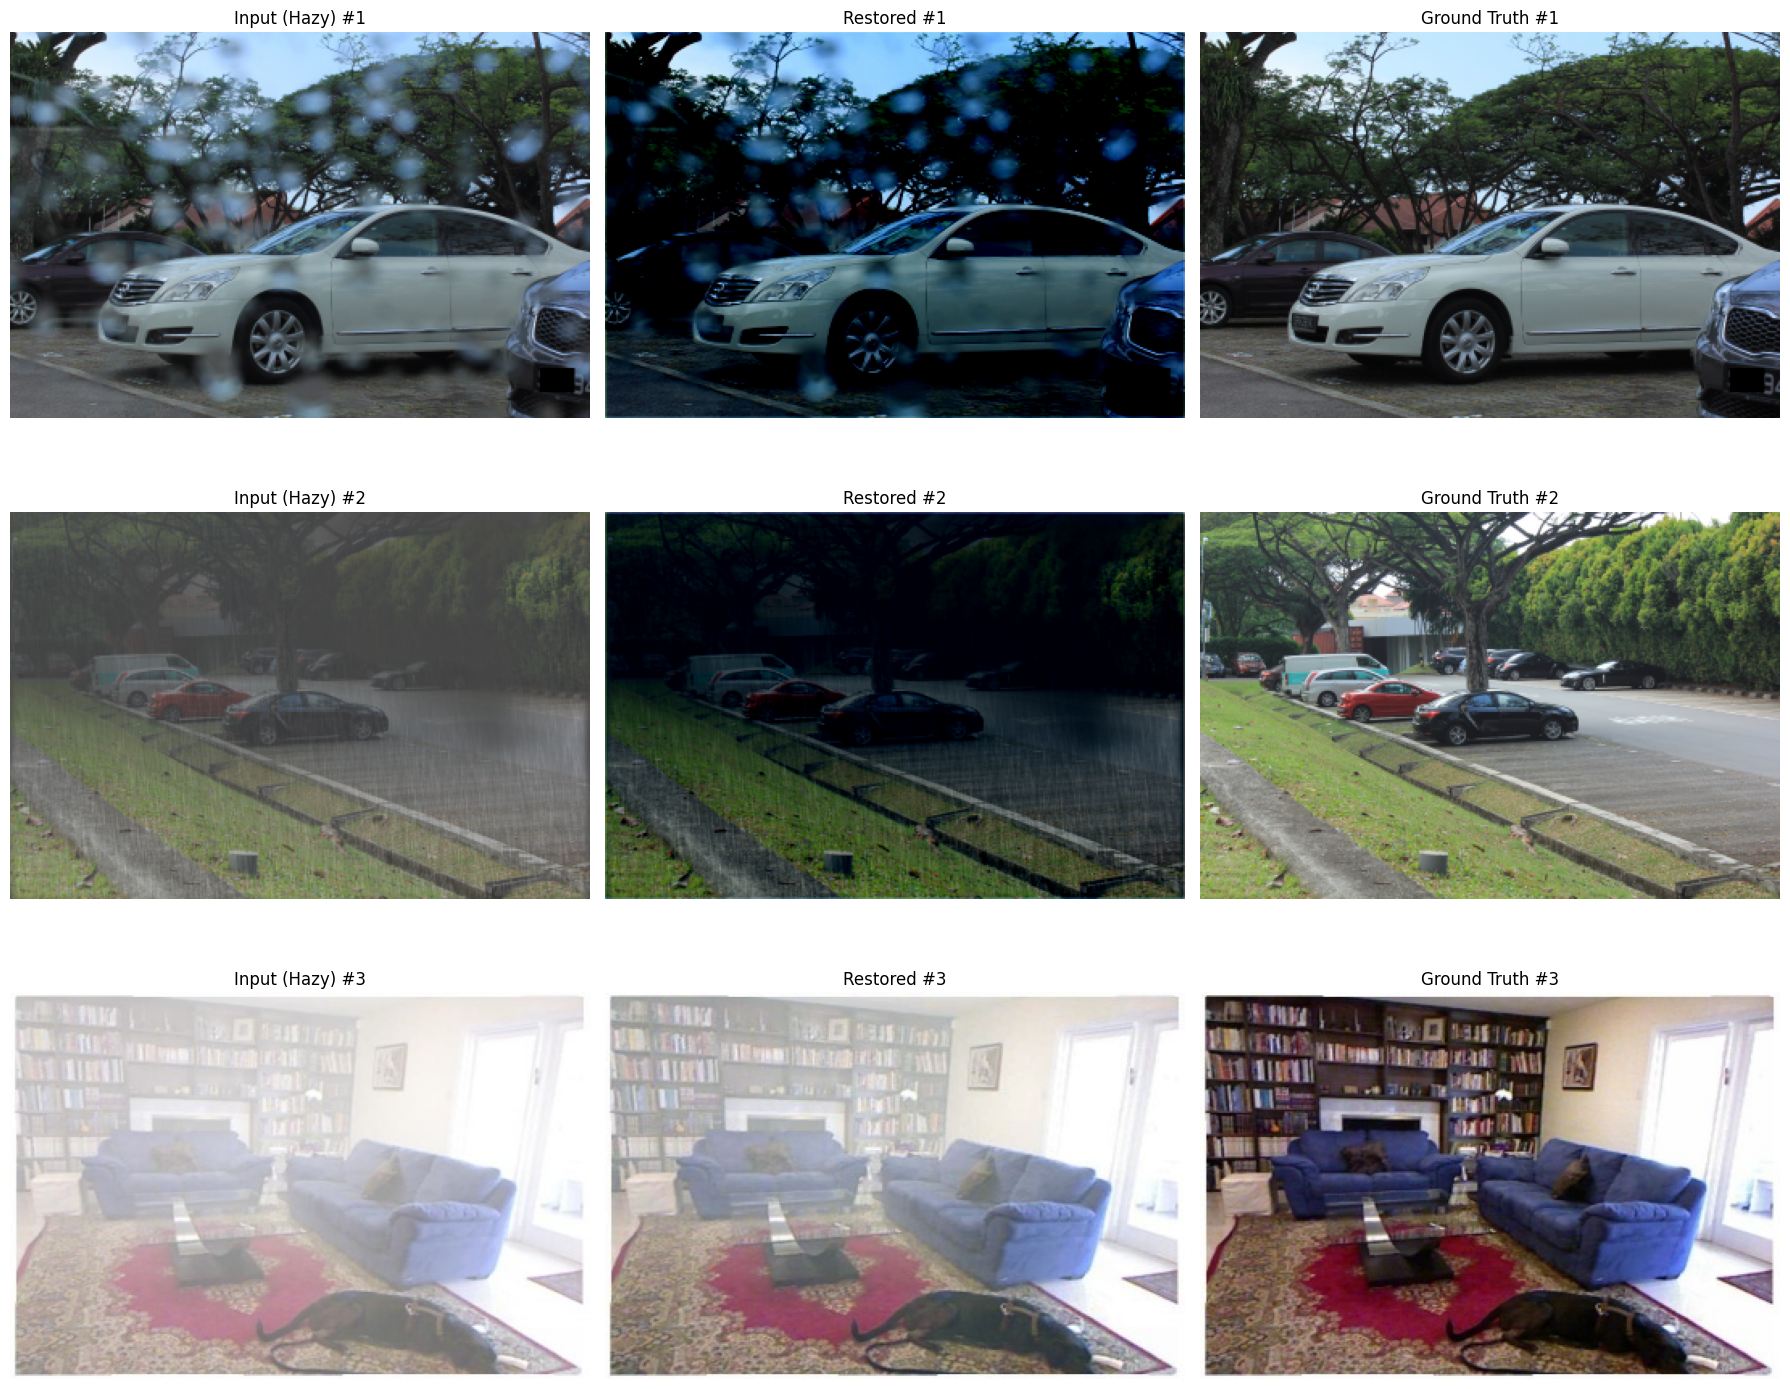


이미지 복원 및 비교 완료!


In [10]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
import os

# --- 설정 (★★★ 사용 전 꼭 수정해주세요 ★★★) ---
# 1. 불러올 학습된 모델 가중치 파일의 경로
MODEL_WEIGHTS_PATH = "pt/aodNet/best_model_epoch_96.pth"

# 2. 복원할 안개 이미지(input) 파일 경로들을 리스트 형태로 지정
HAZY_IMAGE_PATHS = [
    "dataset_split/test/input/51_rain.png",
    "dataset_split/test/input/im_0048_s95_a06.png",
    "dataset_split/test/input/NYU2_1331.jpg"
]

# 3. 정답 이미지(gt)가 들어있는 폴더 경로
GT_BASE_DIR = "dataset_split/test/gt"

# 4. 모델 학습 시 사용했던 이미지 해상도
TARGET_IMAGE_SIZE = (240, 360)
# ----------------------------------------------------------------------

# 모델 구조 로드 및 가중치 불러오기
evaluation_model = AOD_pono_net().to(DEVICE) # DEVICE는 이전 셀에서 정의됨
evaluation_model.load_state_dict(torch.load(MODEL_WEIGHTS_PATH, map_location=DEVICE))
evaluation_model.eval()

# 이미지 전처리 transform 정의
transform = transforms.Compose([
    transforms.Resize(TARGET_IMAGE_SIZE),
    transforms.ToTensor()
])

# 결과를 저장할 리스트 생성
hazy_images_pil = []
restored_images_pil = []
clean_images_pil = []

print("이미지 복원을 시작합니다...")

for hazy_path in HAZY_IMAGE_PATHS:
    try:
        filename = os.path.basename(hazy_path)
        
        # ★★★ 수정된 부분 ★★★
        # os.path.join으로 생성된 경로를 os.path.normpath로 정규화
        clean_path_raw = os.path.join(GT_BASE_DIR, filename)
        clean_path = os.path.normpath(clean_path_raw)
        
        if not os.path.exists(clean_path):
            print(f"경고: 짝이 되는 정답 이미지 '{clean_path}'를 찾을 수 없습니다. 건너뜁니다.")
            continue

        hazy_image = Image.open(hazy_path).convert('RGB')
        clean_image = Image.open(clean_path).convert('RGB')
        
        hazy_tensor = transform(hazy_image).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            restored_tensor = evaluation_model(hazy_tensor)

        restored_image = transforms.ToPILImage()(restored_tensor.squeeze(0).cpu())

        hazy_images_pil.append(hazy_image)
        restored_images_pil.append(restored_image)
        clean_images_pil.append(clean_image)
        print(f"'{hazy_path}' 복원 및 정답 이미지 로드 완료.")

    except FileNotFoundError:
        print(f"오류: '{hazy_path}' 파일을 찾을 수 없습니다. 경로를 다시 확인해주세요.")
    except Exception as e:
        print(f"'{hazy_path}' 처리 중 오류 발생: {e}")

# --- 시각화 부분 ---
if hazy_images_pil:
    num_images = len(hazy_images_pil)
    # 3개의 행(이미지 쌍), 3개의 열(Input, Restored, GT)
    plt.figure(figsize=(18, 5 * num_images)) 

    for i in range(num_images):
        # --- i번째 이미지 쌍 ---
        
        # 1열: 입력(Hazy) 이미지
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(hazy_images_pil[i])
        plt.title(f'Input (Hazy) #{i+1}')
        plt.axis('off')

        # 2열: 복원된 이미지
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(restored_images_pil[i])
        plt.title(f'Restored #{i+1}')
        plt.axis('off')
        
        # 3열: 정답(GT) 이미지
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(clean_images_pil[i])
        plt.title(f'Ground Truth #{i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    print("\n이미지 복원 및 비교 완료!")

In [ ]:
# 객체 탐지 추가 yolo 사용